# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using Visible region data which is obtained after data augmentation (Synthesizing refractive index data) using the sellmeier equation



In [ ]:
# Install keras
# !pip install keras==2.1.6

In [ ]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [ ]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing our uv_vis augmented data, currently using github hosted file.
This data is a result of data augmentation (Synthesizing refractive index data) using the sellmeier equation.

Data was increased from 1807 to 252770 rows


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/uv_visAugmentedData5000books.csv")
df.head()

,book,wl,n,k
0,22,0.4465,1.368170,0.000000e+00
1,22,0.3916,1.373850,2.109850e-07
2,6,0.6850,1.411420,0.000000e+00
3,36,0.4850,1.362881,0.000000e+00
4,18,0.5011,1.345787,0.000000e+00


# Data visualization and pre-processing

In [ ]:
# Shape of the dataframe
df.shape

(252770, 4)

## One hot encoding targets (Classes of organic compounds) with integers

## Grouping data by wavelengths in 'UV' & 'Visible' in regions

In [ ]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,55,0.586818,1.329276,0.0
1,55,0.583719,1.329547,0.0
2,18,0.581092,1.338357,0.0
3,59,0.279140,1.462026,0.0
4,11,0.308638,1.551949,0.0


In [ ]:
# Describing the uv_vis data
df.describe()

,book,wl,n,k
count,252770.000000,252770.000000,252770.000000,252770.000000
mean,29.098956,0.379741,1.712891,0.000095
std,16.922419,0.215232,1.613322,0.006978
min,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.194704,1.399663,0.000000
50%,28.000000,0.382628,1.479020,0.000000
75%,43.000000,0.566004,1.596736,0.000000
max,59.000000,0.750000,44.076235,0.809000


In [ ]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,np.inf], labels= ['UV', 'Visible'])
df.sample(3)

,book,wl,n,k,wl_range
221265,53,0.488893,1.464087,0.0,Visible
227639,21,0.370666,1.418693,0.0,UV
54518,22,0.019640,5.836288,0.0,UV


Let’s see how many of each class is in our data set

In [ ]:
df['wl_range'].value_counts()

UV         132314
Visible    120455
Name: wl_range, dtype: int64

UV increased by 130507 rows

Visible increased by 115187 rows 

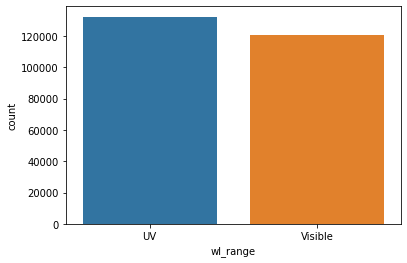

In [ ]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [ ]:
# Lets select only rows within UV region
df = df.loc[df['wl_range'].isin(['UV'])]
df.head()

,book,wl,n,k,wl_range
3,59,0.279140,1.462026,0.0,UV
4,11,0.308638,1.551949,0.0,UV
6,42,0.345852,1.526063,0.0,UV
11,18,0.342269,1.366982,0.0,UV
13,38,0.376569,1.439556,0.0,UV


In [ ]:
# Describe new df with only UV region data
df.describe()

,book,wl,n,k
count,132314.000000,132314.000000,132314.000000,132314.000000
mean,29.237488,0.202431,1.967577,0.000176
std,16.914677,0.115429,2.194461,0.009644
min,0.000000,0.000001,0.021339,0.000000
25%,15.000000,0.102456,1.432237,0.000000
50%,28.000000,0.203675,1.525488,0.000000
75%,43.000000,0.302511,1.687551,0.000000
max,59.000000,0.400000,44.076235,0.809000


In [ ]:
df.shape

(132314, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [ ]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (132314, 3)
Targets (y):  (132314,)


## Normalizing Data


In [ ]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
189279,-1.430487,0.408271,-0.018276
179825,1.383621,-0.239539,-0.018276
72104,1.702949,-0.247055,-0.018276
86553,-0.518406,-0.151283,-0.018276
96391,-1.426439,1.396832,-0.018276
141555,-1.124609,-0.290022,-0.018276
113775,0.597056,-0.207446,-0.018276
86289,-0.908960,-0.229336,-0.018276
141171,1.139501,-0.267529,-0.018276
208232,-0.055714,-0.191973,0.001186


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [ ]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [ ]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (105851, 3)
y - Train shape:  (105851,)
X - Test shape:  (26463, 3)
y - Test shape:  (26463,)


In [ ]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 60 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

60


In [ ]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(100, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 300

In [ ]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               400       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 60)                6060      
                                                                 
Total params: 26,660
Trainable params: 26,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train, validate & test
# We are removing 20% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.2, epochs = epochs, verbose=2)

Epoch 1/300
2647/2647 - 7s - loss: 2.4483 - accuracy: 0.2169 - val_loss: 1.8597 - val_accuracy: 0.3132 - 7s/epoch - 2ms/step
Epoch 2/300
2647/2647 - 6s - loss: 1.6289 - accuracy: 0.3850 - val_loss: 1.4431 - val_accuracy: 0.4298 - 6s/epoch - 2ms/step
Epoch 3/300
2647/2647 - 5s - loss: 1.3951 - accuracy: 0.4562 - val_loss: 1.2678 - val_accuracy: 0.5015 - 5s/epoch - 2ms/step
Epoch 4/300
2647/2647 - 6s - loss: 1.2566 - accuracy: 0.5001 - val_loss: 1.1633 - val_accuracy: 0.5329 - 6s/epoch - 2ms/step
Epoch 5/300
2647/2647 - 6s - loss: 1.1764 - accuracy: 0.5248 - val_loss: 1.1353 - val_accuracy: 0.5610 - 6s/epoch - 2ms/step
Epoch 6/300
2647/2647 - 6s - loss: 1.1107 - accuracy: 0.5484 - val_loss: 1.1259 - val_accuracy: 0.5348 - 6s/epoch - 2ms/step
Epoch 7/300
2647/2647 - 6s - loss: 1.0669 - accuracy: 0.5617 - val_loss: 1.1296 - val_accuracy: 0.5408 - 6s/epoch - 2ms/step
Epoch 8/300
2647/2647 - 5s - loss: 1.0320 - accuracy: 0.5736 - val_loss: 1.0437 - val_accuracy: 0.5513 - 5s/epoch - 2ms/step


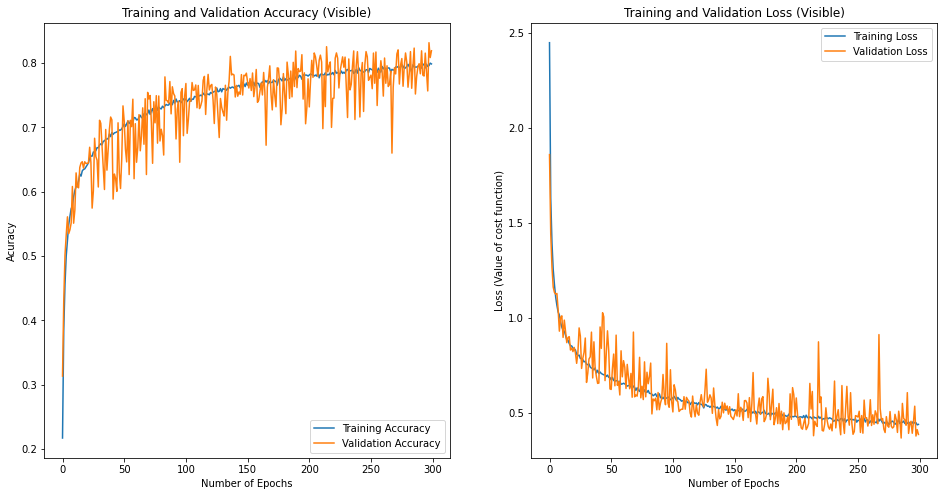

In [ ]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Visible)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Visible)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [ ]:
# # Save model as h5 (keras model) - 0.81
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Aug_UV_5000books_organic_model.h5')

In [ ]:
# # Save the entire model as a SavedModel in drive - 0.81
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Aug_UV_5000books_organic_model') 

# Model Evaluation

In [ ]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.8174432516098022
The test Loss is:  0.38530266284942627


In [ ]:
# Classification report
y_pred = model.predict(x_test) # Whole test set

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       559
           1       0.91      0.85      0.88       513
           3       0.86      0.80      0.83       568
           5       0.90      0.75      0.82       568
           6       0.75      0.91      0.82       550
           7       0.81      0.95      0.87       503
           8       0.92      0.83      0.87       547
           9       0.90      0.93      0.91       547
          10       0.94      0.80      0.87       542
          11       0.86      0.82      0.84       557
          13       0.77      0.93      0.84       533
          14       0.90      0.99      0.94       535
          15       0.90      0.88      0.89       509
          17       0.33      0.95      0.49       548
          18       0.76      0.99      0.86       558
          19       0.39      0.06      0.10       548
          20       0.82      0.82      0.82       584
          21       0.70    